In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/GitHub/ERA-V1/Assignments/S8

KeyboardInterrupt: ignored

# Import Libraries

In [ ]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations



In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       #transforms.RandomCrop(28, padding=4),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model

In [ ]:
%%writefile model.py
import torch
import torch.nn as nn
import torch.nn.functional as F



class Model1(nn.Module):
    def __init__(self, norm='bn'):

        dropout_value = 0.02
        GROUP_SIZE = 8

        super(Model1, self).__init__()

        self.C1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value))

        if norm == 'bn':
            self.n1 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n1 = nn.GroupNorm(GROUP_SIZE, 16)
        elif norm == 'ln':
            self.n1 = nn.GroupNorm(1, 16)

        self.C2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value))

        if norm == 'bn':
            self.n2 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n2 = nn.GroupNorm(GROUP_SIZE, 16)
        elif norm == 'ln':
            self.n2 = nn.GroupNorm(1, 16)

        self.c3t = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=1, stride=1, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value))

        if norm == 'bn':
            self.n3t = nn.BatchNorm2d(8)
        elif norm == 'gn':
            self.n3t = nn.GroupNorm(GROUP_SIZE, 8)
        elif norm == 'ln':
            self.n3t = nn.GroupNorm(1, 8)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.C3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value))

        if norm == 'bn':
            self.n3 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n3 = nn.GroupNorm(GROUP_SIZE, 16)
        elif norm == 'ln':
            self.n3 = nn.GroupNorm(1, 16)


        self.C4 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value))

        if norm == 'bn':
            self.n4 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n4 = nn.GroupNorm(GROUP_SIZE, 16)
        elif norm == 'ln':
            self.n4 = nn.GroupNorm(1, 16)

        self.C5 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value))

        if norm == 'bn':
            self.n5 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n5 = nn.GroupNorm(GROUP_SIZE, 16)
        elif norm == 'ln':
            self.n5 = nn.GroupNorm(1, 16)

        self.c6 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=1, stride=1, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value))

        if norm == 'bn':
            self.n6t = nn.BatchNorm2d(8)
        elif norm == 'gn':
            self.n6t = nn.GroupNorm(GROUP_SIZE, 8)
        elif norm == 'ln':
            self.n6t = nn.GroupNorm(1, 8)

        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.C7 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value))

        if norm == 'bn':
            self.n6 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n6 = nn.GroupNorm(GROUP_SIZE, 16)
        elif norm == 'ln':
            self.n6 = nn.GroupNorm(1, 16)

        self.C8 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value))

        if norm == 'bn':
            self.n7 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n7 = nn.GroupNorm(GROUP_SIZE, 16)
        elif norm == 'ln':
            self.n7 = nn.GroupNorm(1, 16)

        self.C9 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False))
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1))
        self.C10 = nn.Sequential(
            nn.Conv2d(16, 10, kernel_size=1, stride=1, bias=False))

    def forward(self, x):
        x = self.n1(self.C1(x))
        x = self.n2(self.C2(x))
        x = self.pool1(self.n3t(self.c3t(x)))
        skip1 = self.n3(self.C3(x))
        x = self.n4(self.C4(skip1))
        x = self.n5(self.C5(x) + skip1)
        x = self.n6t(self.pool2(self.c6(x)))
        skip2 = self.n6(self.C7(x))
        x = self.n7(self.C8(skip2))
        x = self.C9(x) + skip2
        x = self.gap(x)
        x = self.C10(x)
        x = x.view((x.shape[0],-1))
        x = F.log_softmax(x, dim=1)

        return x

Overwriting model.py


In [ ]:
from model import Model1 as Net

# Model Params

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(norm='bn').to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
           Dropout-3           [-1, 16, 32, 32]               0
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
              ReLU-6           [-1, 16, 32, 32]               0
           Dropout-7           [-1, 16, 32, 32]               0
       BatchNorm2d-8           [-1, 16, 32, 32]              32
            Conv2d-9            [-1, 8, 32, 32]             128
             ReLU-10            [-1, 8, 32, 32]               0
          Dropout-11            [-1, 8, 32, 32]               0
      BatchNorm2d-12            [-1, 8, 32, 32]              16

# Training and Testing



In [ ]:
%%writefile utils.py
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

def plot_graph():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

Overwriting utils.py


In [ ]:
from utils import train, test, plot_graph

# Let's Train and test our model

In [1]:
model = Net(norm='bn').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = F.nll_loss
num_epochs = 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, threshold=1e-2, verbose=True, factor=0.5)


for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test_loss = test(model, device, test_loader, criterion)
  scheduler.step(test_loss)

NameError: ignored

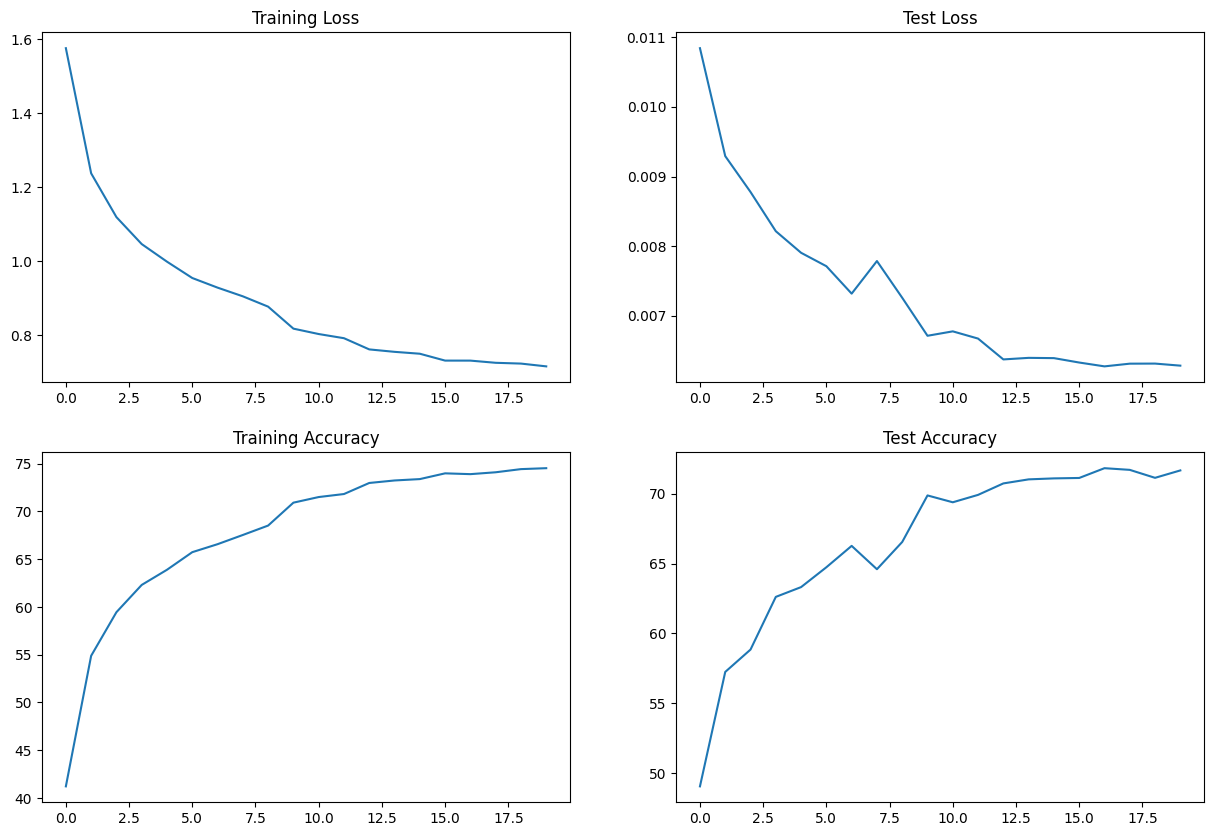

In [ ]:
plot_graph()

In [1]:
import torch
import numpy
import torchvision.datasets as datasets
from torchvision import transforms

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

imgs = [item[0] for item in cifar_trainset] # item[0] and item[1] are image and its label
imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

100%|██████████| 170498071/170498071 [00:14<00:00, 11769872.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768
